<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/Inception_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inception Layer

##Introduction

An inception network is a deep neural network with an architectural design that consists of repeating components referred to as Inception modules. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues. The solution, in short, is to take multiple kernel filter sizes within the CNN, and rather than stacking them sequentially, ordering them to operate on the same level. 

In this notebook, we will use this technique to train our CNN and compare the results with the previous models we have built.

##How it works

Inception Modules are incorporated into convolutional neural networks (CNNs) as a way of reducing computational expense. As a neural net deals with a vast array of images, with wide variation in the featured image content, also known as the salient parts, they need to be designed appropriately. The most simplified version of an inception module works by performing a convolution on an input with not one, but three different sizes of filters (1x1, 3x3, 5x5). Also, max pooling is performed. Then, the resulting outputs are concatenated and sent to the next layer. By structuring the CNN to perform its convolutions on the same level, the network gets progressively wider, not deeper. 

This is the structure of a basic Inception Module:

* Input layer
* 1x1 convolution layer
* 3x3 convolution layer
* 5x5 convolution layer
* Max pooling layer
* Concatenation layer

Below you can see the architecture of a Naive Inception Module:

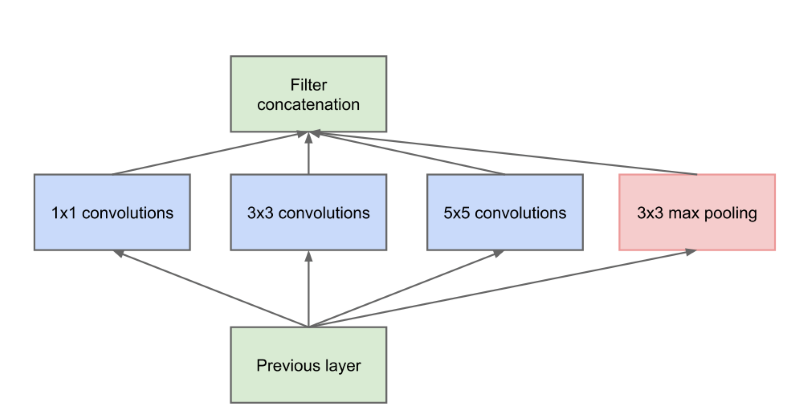

To make the process even less computationally expensive, the neural network can be designed to add an extra 1x1 convolution before the 3x3 ad 5x5 layers. By doing so, the number of input channels is limited and 1x1 convolutions are far cheaper than 5x5 convolutions. It is important to note, however, that the 1x1 convolution is added after the max-pooling layer, rather than before. 

This is the complete Inception module, with the addition of 1x1 convolutional layers: 

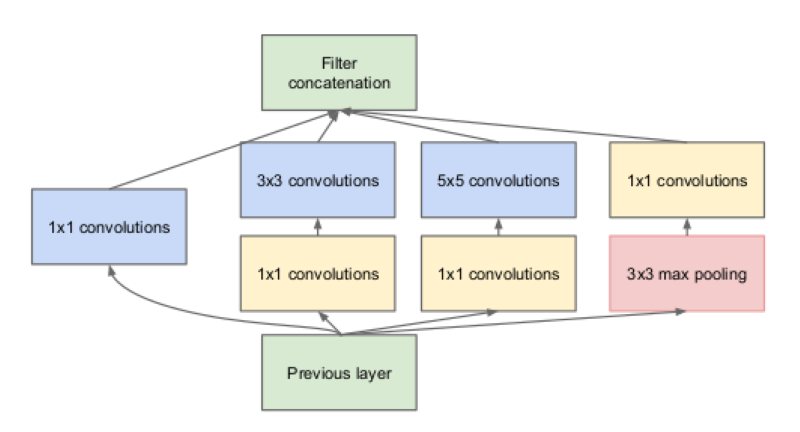

In this way, we decrease by far the computational cost within the Inception Module, reducing depth in input and the number of multiplication operations.
Now we will show the implementation of this two architectures.

#Setup

## Import libraries

In [1]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [2]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [3]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42

## Load dataset

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [6]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [7]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [8]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

# Naive Inception Module

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

In [10]:
def naive_inception_module(layer_in, filter1, filter2, filter3):
 conv1 = layers.Conv2D(filter1, (1,1), padding='same', activation='relu')(layer_in)
 conv3 = layers.Conv2D(filter2, (3,3), padding='same', activation='relu')(layer_in)
 conv5 = layers.Conv2D(filter3, (5,5), padding='same', activation='relu')(layer_in)
 pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
 layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
 return layer_out

## Model definition

In [11]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
x = naive_inception_module(x, 64, 128, 32)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = naive_inception_module(x, 128, 256, 64)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 32)   896         ['sequential[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['conv2d[0][0]']             

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.8073 - accuracy: 0.3145
Epoch 1: val_loss improved from inf to 1.79819, saving model to /content/drive/My Drive/project/models/naive_inception_module/naive_inception_module.h5
55/55 [==============================] - 32s 298ms/step - loss: 1.8073 - accuracy: 0.3145 - val_loss: 1.7982 - val_accuracy: 0.3017
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4593 - accuracy: 0.4589
Epoch 2: val_loss improved from 1.79819 to 1.48209, saving model to /content/drive/My Drive/project/models/naive_inception_module/naive_inception_module.h5
55/55 [==============================] - 16s 269ms/step - loss: 1.4593 - accuracy: 0.4589 - val_loss: 1.4821 - val_accuracy: 0.4594
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3328 - accuracy: 0.5152
Epoch 3: val_loss improved from 1.48209 to 1.45425, saving model to /content/drive/My Drive/project/models/naive_inception_module/naive_incepti

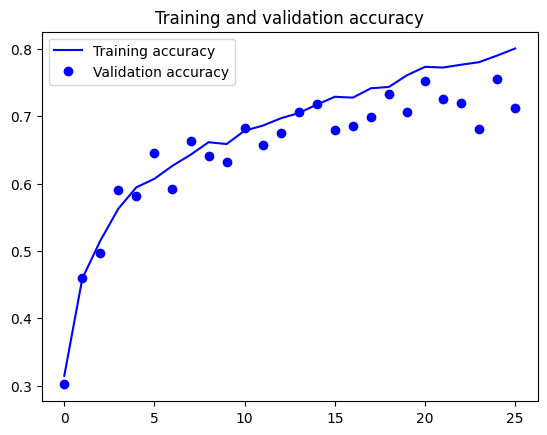

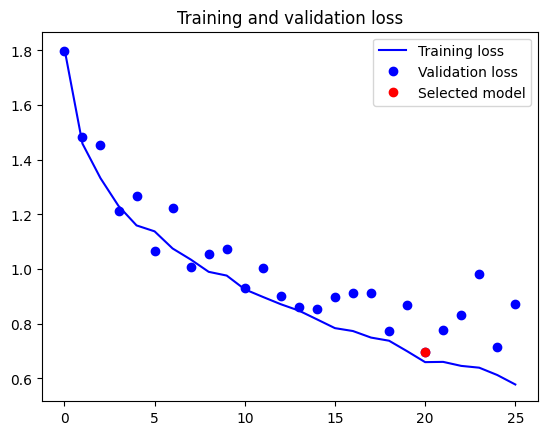

Lowest validation loss has been reached at epoch 20 with validation accuracy of 0.752


In [12]:
model_name = "naive_inception_module"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 4s 175ms/step - loss: 0.6547 - accuracy: 0.7728
Test accuracy: 0.773, test loss: 0.655
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.2323    0.8503    0.3650       147
           1     0.9504    0.8094    0.8742      1112
           2     0.7802    0.6263    0.6948       289
           3     0.8182    0.1837    0.3000        98
           4     0.8011    0.8545    0.8270       165
           5     0.8248    0.6701    0.7395       288
           6     0.7246    0.3817    0.5000       131
           7     0.6545    0.7347    0.6923        98

    accuracy                         0.7216      2328
   macro avg     0.7233    0.6388    0.6241      2328
weighted avg     0.8271    0.7216    0.7469      2328



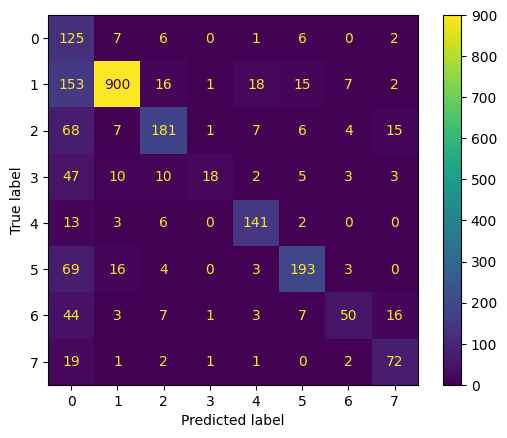

In [13]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations


The model performs quite well in terms of accuracy and loss, however, it starts to overfit from around epoch 10. This could be due to the model's complexity, which ultimately fails to converge, despite achieving decent results on both the validation and test sets.

# Complete Inception Module

In [14]:
def complete_inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
 conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

 conv3 = layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
 conv3 = layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)

 conv5 = layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
 conv5 = layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)

 pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
 pool = layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

 layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
 return layer_out

## Model definition

In [15]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
x = complete_inception_module(x, 64, 96, 128, 16, 32, 32)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = complete_inception_module(x, 128, 128, 192, 32, 96, 64)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 56, 56, 32)   896         ['sequential[1][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 14, 14, 32)  0           ['conv2d_8[0][0]']         

Epoch 1/100
54/55 [============================>.] - ETA: 0s - loss: 1.8405 - accuracy: 0.2980
Epoch 1: val_loss improved from inf to 1.56972, saving model to /content/drive/My Drive/project/models/complete_inception_module/complete_inception_module.h5
55/55 [==============================] - 23s 265ms/step - loss: 1.8369 - accuracy: 0.2997 - val_loss: 1.5697 - val_accuracy: 0.4358
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.5112 - accuracy: 0.4470
Epoch 2: val_loss did not improve from 1.56972
55/55 [==============================] - 15s 246ms/step - loss: 1.5112 - accuracy: 0.4470 - val_loss: 1.6545 - val_accuracy: 0.4147
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.4140 - accuracy: 0.4857
Epoch 3: val_loss improved from 1.56972 to 1.50027, saving model to /content/drive/My Drive/project/models/complete_inception_module/complete_inception_module.h5
55/55 [==============================] - 15s 256ms/step - loss: 1.4140 - accuracy: 0

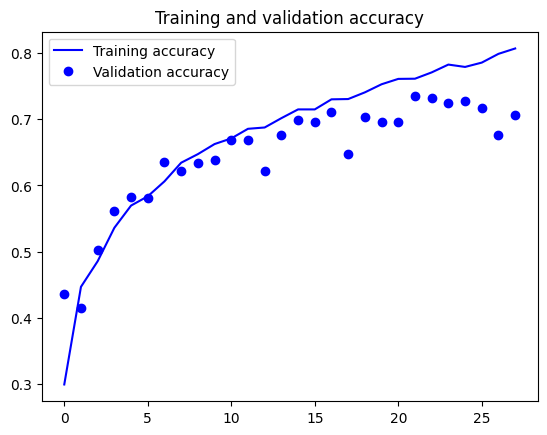

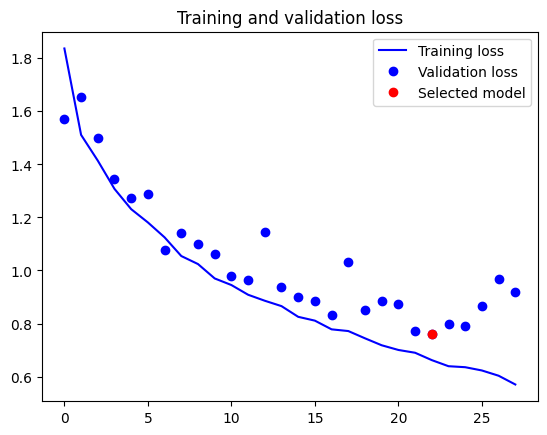

Lowest validation loss has been reached at epoch 22 with validation accuracy of 0.732


In [16]:
model_name = "complete_inception_module"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 3s 165ms/step - loss: 0.6774 - accuracy: 0.7659
Test accuracy: 0.766, test loss: 0.677
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 3 0]
              precision    recall  f1-score   support

           0     0.2180    0.7891    0.3417       147
           1     0.9383    0.8076    0.8681      1112
           2     0.8164    0.5848    0.6815       289
           3     0.5584    0.4388    0.4914        98
           4     0.7965    0.8303    0.8131       165
           5     0.8524    0.6215    0.7189       288
           6     0.5897    0.5267    0.5565       131
           7     0.7679    0.4388    0.5584        98

    accuracy                         0.7105      2328
   macro avg     0.6922    0.6297    0.6287      2328
weighted avg     0.8143    0.7105    0.7429      2328



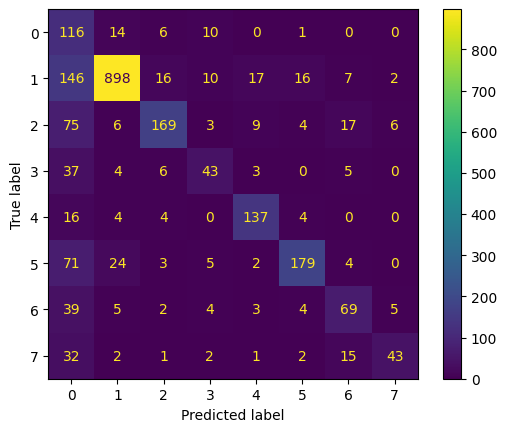

In [17]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations


The use of the complete inception module allowed us to drastically reduce the complexity of the network, obtaining results in line with the previous model, if not even better. However, the problem of model convergence remains: the network fails to converge until towards the end of the training process.

#Hyperparameter tuning

## Setup

In [18]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.1 MB/s eta 0:00:00


In [19]:
import keras_tuner as kt

my_dir = "/content/drive/My Drive/tuner"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

## Model builder

In [20]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp = hp.Float('dropout_rate', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation=activation_hp)(x)
  x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
  x = complete_inception_module(x, 64, 96, 128, 16, 32, 32)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = complete_inception_module(x, 128, 128, 192, 32, 96, 64)
  x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=activation_hp)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(hp_units)(x)
  x = layers.Dropout(dropout_rate_hp)(x)
  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='inception_module_hptuning')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [21]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=25,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'gelu'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


Perform search for the best hyperparameters. 

In [24]:
tuner.search(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 30 Complete [00h 04m 02s]
val_accuracy: 0.7580575942993164

Best val_accuracy So Far: 0.7730984091758728
Total elapsed time: 00h 56m 39s
The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 320 and         the optimal learning rate for the optimizer is 0.001.


In [25]:
tuner.results_summary()

Results summary
Results in /content/drive/My Drive/tuner/logs/0504-1252/model_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
activation_function: gelu
units: 320
learning_rate: 0.001
dropout_rate: 0.24713996898052154
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.7730984091758728

Trial 0017 summary
Hyperparameters:
activation_function: gelu
units: 128
learning_rate: 0.001
dropout_rate: 0.13418519969021508
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.7696605324745178

Trial 0025 summary
Hyperparameters:
activation_function: gelu
units: 352
learning_rate: 0.001
dropout_rate: 0.15146600816576017
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.7670820951461792

Trial 0016 summary
Hyperparameters:
activation_function: gelu
units: 160
learning_rate: 0.001
dropou

## Train model with the best hyperparameters

In [26]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=stop_early)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
55/55 [==============================] - 28s 397ms/step - loss: 1.6131 - accuracy: 0.4111 - val_loss: 1.3411 - val_accuracy: 0.5681
Epoch 2/50
55/55 [==============================] - 20s 337ms/step - loss: 1.2187 - accuracy: 0.5707 - val_loss: 1.0957 - val_accuracy: 0.6541
Epoch 3/50
55/55 [==============================] - 14s 236ms/step - loss: 1.0339 - accuracy: 0.6375 - val_loss: 1.0940 - val_accuracy: 0.6150
Epoch 4/50
55/55 [==============================] - 15s 236ms/step - loss: 0.9204 - accuracy: 0.6757 - val_loss: 0.9178 - val_accuracy: 0.6743
Epoch 5/50
55/55 [==============================] - 14s 245ms/step - loss: 0.8229 - accuracy: 0.7136 - val_loss: 0.9546 - val_accuracy: 0.6837
Epoch 6/50
55/55 [==============================] - 16s 263ms/step - loss: 0.7494 - accuracy: 0.7375 - val_loss: 1.0452 - val_accuracy: 0.6394
Epoch 7/50
55/55 [==============================] - 14s 244ms/step - loss: 0.6954 - accuracy: 0.7636 - val_loss: 0.7948 - val_accuracy: 0.7301

In [27]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset, callbacks=stop_early)

Epoch 1/10
55/55 [==============================] - 20s 241ms/step - loss: 1.6919 - accuracy: 0.3601 - val_loss: 1.3638 - val_accuracy: 0.5466
Epoch 2/10
55/55 [==============================] - 16s 261ms/step - loss: 1.2363 - accuracy: 0.5554 - val_loss: 1.2326 - val_accuracy: 0.5896
Epoch 3/10
55/55 [==============================] - 14s 247ms/step - loss: 1.0583 - accuracy: 0.6320 - val_loss: 0.9740 - val_accuracy: 0.6592
Epoch 4/10
55/55 [==============================] - 14s 243ms/step - loss: 0.9749 - accuracy: 0.6521 - val_loss: 1.0529 - val_accuracy: 0.6442
Epoch 5/10
55/55 [==============================] - 15s 249ms/step - loss: 0.8633 - accuracy: 0.7009 - val_loss: 0.8977 - val_accuracy: 0.6927
Epoch 6/10
55/55 [==============================] - 14s 245ms/step - loss: 0.7716 - accuracy: 0.7286 - val_loss: 0.9320 - val_accuracy: 0.6932
Epoch 7/10
55/55 [==============================] - 14s 246ms/step - loss: 0.7104 - accuracy: 0.7570 - val_loss: 1.0571 - val_accuracy: 0.6704

In [28]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

19/19 [==============================] - 3s 171ms/step - loss: 0.7333 - accuracy: 0.7719
[test loss, test accuracy]: [0.7333306670188904, 0.7719072103500366]
